In [557]:
from scipy import optimize, stats
from Auction.Auction import Auction
from Auction.SecondPriceAuction import SecondPriceAuction
#import GeneralizedFirstPriceAuction as gfpa
from Auction.MultiplicativePacingAgent import MultiplicativePacingAgent
import numpy as np
import matplotlib.pyplot as plt
import argparse
#from Auction.UCBAgent import UCBAgent
#from Punto2.Auction.EXP3P import EXP3PAgent

#pricing
from Pricing.GPThompson import GPThompson
from Pricing.GPUCBAgent import GPUCBAgent
from Pricing.GPThompsonContinuous import GPThompsonContinuous
from Pricing.GPUCBAgentContinuous import GPUCBAgentContinuous
from Pricing.StochasticPricingEnvironment import StochasticPricingEnvironment
from visualization import showPlotRegrets,showCombinedPlots,showPlotPulls

import numpy as np 

In [558]:
#generalized1stpriceauctionclass
class GeneralizedFirstPriceAuction(Auction):
    """
    ctrs is the conversion rate of the users
    n_adv is the number of advertisers
    """
    def __init__(self, ctrs, n_spots=1):
        self.ctrs = ctrs
        self.n_spots = n_spots
        self.n_adv = len(self.ctrs)
        self.visibility = (0.9)**np.array(range(n_spots))
        
    
    def get_winners(self, bids):
        #adv_values = self.ctrs*bids
        adv_values = bids
        adv_ranking = np.argsort(adv_values)
        winners = adv_ranking[-self.n_spots:]
        return winners, self.visibility, adv_values[-self.n_spots:]
    
    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]
        payment = values[second]/self.ctrs[winners]
        return payment.round(2)

In [559]:
#EXP3P
class EXP3PAgent:
    def __init__(self, K, learning_rate, gamma, T):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)* ((learning_rate*gamma/3) * np.sqrt(T/K) )
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0
        self.gamma = gamma
        self.T= T

    def pull_arm(self):
        self.x_t = (1-self.gamma)*self.weights/sum(self.weights) + self.gamma/self.K
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t/self.K
    
    def update(self, l_t):
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp( self.gamma/(3*self.K)*(l_t_tilde+ self.learning_rate/(self.x_t[self.a_t]*np.sqrt(self.K* self.T))))
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [560]:
#UCB
class UCBAgent:
    def __init__(self,valuation, budget,n_users, T , K, ):
        self.valuation = valuation
        self.budget = budget
        self.T = T
        

        self.t = 0
        self.n_users = n_users
        self.rho = self.budget/(self.T*self.n_users)
        self.K=K
        self.N_pulls = np.zeros(self.K)
        self.bids = np.linspace(0, 1, K)
        self.f_t = np.zeros(self.K)
        self.c_t = np.zeros(self.K)
        self.f_t_UCB = np.zeros(self.K)
        self.c_t_LCB = np.zeros(self.K)
        self.arm=None
    
    def __clacoulate_bounds(self):
        ft_mean = np.zeros(self.K)
        ct_mean = np.zeros(self.K)  
        for i in range(self.K):
            if self.N_pulls[i] == 0:
                ft_mean[i] = 0
                ct_mean[i] = 0
                self.f_t_UCB[i] = 100000
                self.c_t_LCB[i] = -100000
            else:
                ft_mean[i] = self.f_t[i]/self.N_pulls[i]
                ct_mean[i] = self.c_t[i]/self.N_pulls[i]
                self.f_t_UCB[i] = ft_mean[i] + np.sqrt(2*np.log(self.T)/self.N_pulls[i])
                self.c_t_LCB [i]= ct_mean[i] - np.sqrt(2*np.log(self.T)/self.N_pulls[i])
        
        return self.f_t_UCB, self.c_t_LCB
    
    def __solve_problem(self):
        c = -(self.f_t_UCB)
        A_ub = [self.c_t_LCB]
        b_ub = [self.rho]
        A_eq = [np.ones(len(self.c_t_LCB))]
        b_eq = [1]
        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
        gamma = res.x
        return gamma
    
    def __sample(self, gamma):
        self.arm = np.random.choice(np.arange(self.K), p=gamma)
        self.N_pulls[self.arm] += 1
        if self.budget >= 1:
            return self.arm
        else: return 0
    
    def bid(self):
        self.__clacoulate_bounds()
        gamma = self.__solve_problem()
        arm=self.__sample(gamma)
        return self.bids[arm]
    
    def update(self, f_t, c_t):
        self.f_t[self.arm] += f_t
        self.c_t[self.arm] += c_t
        self.budget -= c_t
        
    def update_per_round(self):
        self.t += 1
        if self.t < self.T:
            self.rho = self.budget/((self.T-self.t)*self.n_users)
        else:
            self.rho = self.budget/(self.n_users)


In [561]:
#Multi non truthfull
class NONTRuthfull_MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, n_users, eta, K):
        self.K = K
        self.bids = np.linspace(0,1,self.K)
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.n_users = n_users
        self.rho = self.budget/(self.T*self.n_users)
        self.lmbd = 0
        self.t = 0
        self.w = np.ones(K)/K
        
    def lagrangian_calculation(self, f_t, c_t, lambda_t): 
        return f_t - lambda_t*(c_t - self.rho)    
    
    def calculate_arms_rewards(self, m_t): 
        f = lambda b: (self.valuation - b)*(b>m_t)
        c = lambda b: b*(b>m_t)
        return f(self.bids), c(self.bids)
    
    def bid(self): 
        X_t = self.w / sum(self.w)
        #print(X_t)
        arm = np.random.choice(np.arange(self.K), p = np.array(X_t))
        #print(arm)
        if self.budget>=1:
            return self.bids[arm]
        else: return 0 
            
    def update(self, m_t, e_c_t):
        #c_t expirienced loss
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-e_c_t), 
                            a_min=0, a_max=1/self.rho)
        self.budget -= e_c_t
        f_ts, c_ts = self.calculate_arms_rewards(m_t)
        lagrangians = self.lagrangian_calculation(f_ts, c_ts, self.lmbd)
        self.w = self.w*np.exp(-self.eta*lagrangians)
        
    def update_per_round(self):
        self.t += 1
        if self.t < self.T:
            self.rho = self.budget/((self.T-self.t)*self.n_users)
        else:
            self.rho = self.budget/(self.n_users)    
        
            

In [562]:
# plots
def showPlotPoint4(vett1, vett2, vett3, title,T, budgect=0):

    #plt.plot(np.arange(T)*(vett1>0), vett1*(vett1>0), label='UCB-like')
    #plt.plot(np.arange(T)*(vett2>0), vett2*(vett2>0), label='multi')
    #plt.plot(np.arange(T)*(vett3>0), vett3*(vett3>0), label='NON_truthfull_multi')
    plt.plot(np.arange(T), vett1, label='UCB-like')
    plt.plot(np.arange(T), vett2, label='multi')
    plt.plot(np.arange(T), vett3, label='Non-Truthful multi')
    if budgect > 0:
        plt.plot(np.arange(T), budgect*vett1**0 , label='budject') 
    plt.title(title)
    # plt.plot((0,T-1), (avg_vett1[0], avg_vett1[-1]), 'ro', linestyle="--")
    plt.xlabel('$t$')
    plt.legend()
    plt.show()

def showPlotPoint4Bids(vett1, vett2, vett3, title,T, budgect=0):   
#plt.plot(sampled_vector, marker='o', linestyle='-', markersize=2)
    plt.plot(np.arange(T), vett1, marker='o', linestyle='',  markersize=1, label='UCB-like')
    plt.plot(np.arange(T), vett2, marker='*', linestyle='', markersize=1, label='multi')
    plt.plot(np.arange(T), vett3, marker='.', linestyle='', markersize=1, label='Non-truthful_multi')
    plt.title(title)
    # plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
    plt.xlabel('$t$')
    plt.legend()
    plt.show()
    
def showPlot(vett1, vett2, vett3, title, yaxis, T, n_trials, budgect=0):
    vett1 = np.array(vett1)
    vett2 = np.array(vett2)
    vett3 = np.array(vett3)

    avg_vett1 = vett1.mean(axis=0)
    vett1_sd = vett1.std(axis=0)
    
    avg_vett2 = vett2.mean(axis=0)
    vett2_sd = vett2.std(axis=0)
    
    avg_vett3 = vett3.mean(axis=0)
    vett3_sd = vett3.std(axis=0)

    plt.plot(np.arange(T), avg_vett1, label='UCB-like')
    plt.fill_between(np.arange(T),
                     avg_vett1 - vett1_sd / np.sqrt(n_trials),
                     avg_vett1 + vett1_sd / np.sqrt(n_trials),
                     alpha=0.3)
    
    plt.plot(np.arange(T), avg_vett2, label='multi')
    plt.fill_between(np.arange(T),
                     avg_vett2 - vett2_sd / np.sqrt(n_trials),
                     avg_vett2 + vett2_sd / np.sqrt(n_trials),
                     alpha=0.3)

    plt.plot(np.arange(T), avg_vett3, label='Non-Truthful multi')
    plt.fill_between(np.arange(T),
                     avg_vett3 - vett3_sd / np.sqrt(n_trials),
                     avg_vett3 + vett3_sd / np.sqrt(n_trials),
                     alpha=0.3)
    if budgect > 0:
        plt.plot(np.arange(T), budgect*avg_vett1**0 , label='budget', color = "red", linestyle='--' )
        
    plt.title(title)
    plt.ylabel(yaxis)
    plt.xlabel('$t$')
    plt.legend()
    plt.show()    
    
def showPlotPulls(bids1,bids2,bids3, title, K, best_price_index = 0):
    
    ranges = np.linspace(0, 1, K)
    n_bids1 = np.zeros(K)
    n_bids2 = np.zeros(K)
    n_bids3 = np.zeros(K)
    colors = ['blue', 'orange', 'green']
    
    for ii in range(K):
        n_bids1[ii] = sum(bids1==ranges[ii]) 
        if ii != K-1: 
            n_bids2[ii] = sum((bids2>=ranges[ii])*(bids2<ranges[ii+1])) 
        else: 
            n_bids2[ii] = sum((bids2>=ranges[ii]))    
        n_bids3[ii] = sum(bids3==ranges[ii])
        ''' 
        if ii == K-2:
            n_bids1[ii] = sum((bids1>=ranges[ii])*(bids1<=ranges[ii+1])) 
            n_bids2[ii] = sum((bids2>=ranges[ii])*(bids2<=ranges[ii+1])) 
            n_bids3[ii] = sum((bids3>=ranges[ii])*(bids3<=ranges[ii+1])) 
        '''    
        
    percentage_labels = [f"{int(((i)/K)*100)}" for i in range(K)]
    
    plt.barh(np.arange(K), n_bids1, label= 'UCB-like', color = colors[0], alpha=0.7)
    plt.title("UCB-like bids")
    plt.ylabel('bids in %')
    plt.yticks(np.arange(K), percentage_labels)
    plt.xlim(0, 2000)
    plt.xlabel('Number of bids')
    plt.legend()
    plt.show()
    
    plt.barh(np.arange(K), n_bids2, label= "multi ", color = colors[1], alpha=0.7)
    plt.title("Multi")
    plt.ylabel('bids in %')
    plt.yticks(np.arange(K), percentage_labels)
    plt.xlim(0, 2000)
    plt.xlabel('Number of bids')
    plt.legend()
    plt.show()
    
    plt.barh(np.arange(K), n_bids3, label= "Non-Truthfull multi", color = colors[2], alpha=0.7)
    plt.title("Non-Truthful multi")
    plt.ylabel('bids in %')
    plt.yticks(np.arange(K), percentage_labels)
    plt.xlim(0, 2000)
    plt.xlabel('Number of bids')
    plt.legend()
    plt.show()
    
    #percentage_labels = [f"{int((i/K)*100)}%" for i in range(K)]
    #plt.xticks(np.arange(K), percentage_labels)
        
    '''
    fig, axs = plt.subplots(3, 1)
    axs[0].bar(ranges, n_bids1, label= 'UCB-like', color = colors[0], alpha=0.7)
    axs[0].set_title("UCB-like bids")
    axs[0].set_ylabel('bids')
    axs[0].set_xlabel('$t$')
    axs[0].legend()
    
    axs[1].bar(ranges, n_bids2, label= 'multi', color = colors[1], alpha=0.7)
    axs[1].set_title("Multi bids")
    axs[1].set_ylabel('bids')
    # axs[1].set_xlabel('$t$')
    axs[1].legend()
    
    axs[2].bar(ranges, n_bids3, label= 'Non-Truthfull multi', color = colors[2], alpha=0.7)
    axs[2].set_title("Non-Truthfull multi")
    axs[2].set_ylabel('bids')
    axs[2].set_xlabel('$t$')
    axs[2].legend()
    '''
    
    
'''
    plt.figure()
    plt.barh(np.arange(K), n_pulls1)
    #plt.axhline(best_price_index, color='red', label='Best price')
    plt.ylabel('actions')
    plt.xlabel('numer of pulls')
    plt.legend()
    plt.title('Number of pulls for each action '+title)
    plt.show()
def showTimeBids(bids1, title, K, best_price_index = 0):
    #K number of auctions
    #bids1 bids over the time period
    plt.figure()
    plt.bar(np.arange(K), bids1)
    #plt.axhline(best_price_index, color='red', label='Best price')
    plt.ylabel('actions')
    plt.xlabel('numer of pulls')
    plt.legend()
    plt.title('Number of pulls for each action '+title)
    plt.show()    
'''    
def showTimeBids(bids1,bids2,bids3, title, K, best_price_index = 0):
    #K number of auctions
    #bids1 bids over the time period
       
    
    fig, axs = plt.subplots(1, 3)

    # First plot: Regret for agent_1
    axs[0].bar(np.arange(K), bids1, label= 'UCB-like', alpha=0.7)
    axs[0].set_title("UCB-like bids")
    axs[0].set_ylabel('bids in %')
    axs[0].set_xlabel('$t$')
    axs[0].legend()
    
    axs[1].bar(np.arange(K), bids2, label= 'multi', alpha=0.7)
    axs[1].set_title("Multi bids")
    axs[1].set_ylabel('bids in %')
    axs[1].set_xlabel('$t$')
    axs[1].legend()
    
    axs[2].bar(np.arange(K), bids3, label= 'Non-Truthfull multi', alpha=0.7)
    axs[2].set_title("Non-Truthful multi")
    axs[2].set_ylabel('bids in %')
    axs[2].set_xlabel('$t$')
    axs[2].legend()

In [563]:
#functions

def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

def discretize(T):
    epsilon = T**(-0.33)
    K = int(np.ceil(1/epsilon))
    return K

def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

def initialize_stoch_auctions(args):
    # noise in the environment
    eta = 1/np.sqrt(args.n_users)
    if args.bidding_agent == 'ucb':
        K_disc = discretize(args.T*args.n_users)
        print('INITIALIZING UCB BIDDING AGENT...')
        adv_agent = UCBAgent(
            valuation=args.valuation,
            budget=args.B,
            n_users=args.n_users,
            T=args.T,
            K=K_disc
            
        )
    else:
        print('INITIALIZING MULTIPLICATIVE BIDDING AGENT...')
        adv_agent = MultiplicativePacingAgent(
            valuation=args.valuation,
            budget=args.B,
            T=args.T, 
            n_users= args.n_users,
            eta=eta
        )
    auction = SecondPriceAuction(args.ctrs)


    return auction, adv_agent

def initialize_stoch_pricing(args):
    K = discretize(args.T)
    prices = np.linspace(args.min_price, args.max_price, K)
    reward_function = lambda price, n_sales: (price-args.cost)*n_sales
    maximum_profit = reward_function(max(prices), args.n_customers)
    # the maximum possible reward is selling at the maximum price to every possible customer

    # conversion prob
    conversion_probability = lambda p: 1-p/20 #TODO: try to change it
            
    # clairvoyant
    profit_curve = reward_function(np.linspace(args.min_price, args.max_price, 1000), args.n_customers*conversion_probability(np.linspace(args.min_price, args.max_price, 1000)))
    best_price_index = np.argmax(profit_curve)
    #best_price = prices[best_price_index]
           
           
    expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], args.T)
    if args.discretize_price==1:
        
        if args.pricing_agent == 'ucb':
            print('INITIALIZING DISCRETIZED UCB PRICING AGENT...')
            gp_agent = GPUCBAgent(args.T, discretization=K)
        else:
            print('INITIALIZING DISCRETIZED THOMPSON PRICING AGENT...')
            gp_agent = GPThompson(args.T, discretization=K)    
    else:
        if args.pricing_agent == 'ucb':
            print('INITIALIZING CONTINUOUS UCB PRICING AGENT...')
            gp_agent = GPUCBAgentContinuous(args.T)
        else:
            print('INITIALIZING CONTINUOUS THOMPSON PRICING AGENT...')
            gp_agent = GPThompsonContinuous(args.T)
    env = StochasticPricingEnvironment(
        conversion_probability=lambda p: 1-p/20,
        cost=args.cost
    )
    return gp_agent, env, expected_clairvoyant_rewards 
        
def loop_auction_day(auction, agent1, agent2, agent3, other_bids, seed, n_users=1000):
    utilities1 = np.array([])
    utilities2 = np.array([])
    utilities3 = np.array([])
    
    my_bids1 = np.array([])
    my_bids2 = np.array([])
    my_bids3 = np.array([])
    
    my_payments1 = np.array([])
    my_payments2 = np.array([])
    my_payments3 = np.array([])
    total_wins1 = 0
    total_wins2 = 0
    total_wins3 = 0
    m_t = other_bids.max(axis=0)

    np.random.seed(seed)
    for u in range(n_users):
        # interaction
        my_bid_1 = agent1.bid()
        my_bid_2 = agent2.bid()
        my_bid_3 = agent3.bid()
        #my_bid_3 = agent3.pull_arm()
        
        bids = np.append(my_bid_3, other_bids[:, u].ravel())
        bids = np.append(my_bid_2, bids)
        bids = np.append(my_bid_1, bids)

        m_t = np.max((np.max(bids[0:1]), np.max(bids[3:])))
        
        winners, visibility_vec,  payments_per_click = auction.get_winners(bids=bids)
        #print(winners)
        #print(visibility_vec)
        my_win_1 = np.dot(winners==0, visibility_vec)
        my_win_2 = np.dot(winners==1, visibility_vec)
        my_win_3 = np.dot(winners==2, visibility_vec)
        
        #print("alg_1 wins? ",my_win_1)
        #print("alg_2 wins? ",my_win_2)
        #print("alg_3 wins? ",my_win_3)
        
        f_t1, c_t1 = (args.valuation-my_bid_1)*my_win_1, my_bid_1*(my_win_1>0)
        f_t2, c_t2 = (args.valuation-my_bid_2)*my_win_2, my_bid_2*(my_win_2>0)
        f_t3, c_t3 = (args.valuation-my_bid_3)*my_win_3, my_bid_3*(my_win_3>0)
        
        #print("reward UCB", f_t1)
        #print("revard multi", f_t2)
        
        agent1.update(f_t1, c_t1)
        agent2.update(f_t2, c_t2)
        agent3.update(m_t, c_t3)
        
        # logging
        utilities1 = np.append(utilities1, f_t1)
        utilities2 = np.append(utilities2, f_t2)
        utilities3 = np.append(utilities3, f_t3)
        
        my_bids1 = np.append(my_bids1, my_bid_1)
        my_bids2 = np.append(my_bids2, my_bid_2)
        my_bids3 = np.append(my_bids3, my_bid_3)
        #print(my_bid_3)
        #print(f_t3)
        
        my_payments1 = np.append(my_payments1, c_t1)
        my_payments2 = np.append(my_payments2, c_t2)
        my_payments3 = np.append(my_payments3, c_t3)
        
        total_wins1+=my_win_1
        total_wins2+=my_win_2
        total_wins3+=my_win_3
        
        

    #print(f'Total # of Wins: {total_wins}')
    utilities = np.vstack((utilities1, utilities2, utilities3))
    my_bids = np.vstack((my_bids1, my_bids2, my_bids3))
    #print(my_bids)
    my_payments = np.vstack((my_payments1, my_payments2, my_payments3))
    total_wins = np.vstack((total_wins1, total_wins2, total_wins3))
    #print(total_wins)
    
    return utilities, my_bids, my_payments, total_wins



In [564]:
def parse():
    parser = argparse.ArgumentParser()
    parser.add_argument('--env', type=str, help='type of environment: adversarial or stochastic', default='stochastic')
    parser.add_argument('--problem', type=str, help='Play only pricing, only auction or both', default='auction')
    parser.add_argument('--advertisers', type=int, help='number of advertisers for auction problem', default=4)
    parser.add_argument('--T', type=int, help='number of days', default=5)
    parser.add_argument('--n_users', type=int, help='number of users', default=1000)
    parser.add_argument('--n_customers', type=int, help='number of customers for pricing problem', default=100)
    parser.add_argument('--B', type=int, help='budget for auction problem', default=15000)
    parser.add_argument('--valuation', type=float, help='valuation for auction problem', default=1)
    parser.add_argument('--cost', type=int, help='cost for pricing problem', default=10)
    parser.add_argument('--ctrs', nargs='+', type=float, help='conversion rates for advertisers', default=[1, 1, 1, 1])
    parser.add_argument('--eta', type=float, help='noise in the environment', default=1/np.sqrt(1000))
    parser.add_argument('--min_price', type=int, help='minimum price for pricing problem', default=10)
    parser.add_argument('--max_price', type=int, help='maximum price for pricing problem', default=20)
    parser.add_argument('--pricing_agent', type=str, help="type of agent of the stoch pricing problem", default='ucb')
    parser.add_argument('--bidding_agent', type=str, help="type of agent of the stoch pricing problem", default='ucb')
    parser.add_argument('--discretize_price', type=int, help="discretize the price space", default=1)
    #TODO: ADD DISTRIBUTIONS ARGUMENT

    # Parse known args to avoid Jupyter conflicts
    args, unknown = parser.parse_known_args()

    # If ctrs is not given or is less than the number of advertisers, fill with ones
    if len(args.ctrs) < args.advertisers:
        args.ctrs += [1] * (args.advertisers - len(args.ctrs))
    
    return args

args = parse()

In [565]:
# action UCB
R_TS = []
args.T = 15
args.B = 500
args.n_users = 500
n_epochs = 10
n_spots = 1
gamma = 1
eta = 0.001
args.advertisers = 20
K_disc = discretize(args.T*args.n_users)
n_unfair_competitors = 1

utilities1 = []
utilities2 = []
utilities3 = []

payments1 = []
payments2 = []
payments3 = []

for n in range(n_epochs): 
    
    alg_utilities = np.zeros((3, args.T*args.n_users))
    alg_bids = np.zeros((3, args.T*args.n_users))
    alg_payments = np.zeros((3, args.T*args.n_users))
    m_ts = np.array([])
    
    total_wins_period = [0, 0, 0]
    
    
    auction = GeneralizedFirstPriceAuction(args.ctrs, n_spots)
    UCB_agent = UCBAgent(valuation=args.valuation,budget=args.B,n_users=args.n_users,T=args.T,K=K_disc)
    multi_agent = MultiplicativePacingAgent(valuation=args.valuation, budget=args.B, T=args.T, n_users= args.n_users,eta=eta)
    #EXP3P_Agent = EXP3PAgent(K_disc, eta, gamma, args.T*args.n_users)
    non_truth_multi_agent = NONTRuthfull_MultiplicativePacingAgent(valuation=args.valuation,budget=args.B,n_users=args.n_users,T=args.T,K=K_disc, eta = eta)
    
    for t in range(args.T):
        day_seed = np.random.randint(0, 1000)
        np.random.seed(day_seed)
        change = np.random.uniform(0.1, 0.25)
        #print(change)
        other_bids = np.random.uniform(0, 1, size=(args.advertisers-1, args.n_users))
        non_truthfull_bidder = 1.2*np.random.binomial(n=1, p=1/3, size=(n_unfair_competitors, args.n_users))
        other_bids = np.vstack((other_bids, non_truthfull_bidder))
        
        #other_bids = np.random.uniform(0+change, 1+change, size=(args.advertisers-1, args.n_users))
        #a = 1*(1+t/args.T)
        a = 1
        b = 1
        #other_bids = 1.5*np.random.beta(a, b, size=(args.advertisers - 1, args.n_users))
        total_wins_period = [0, 0, 0]

        utilities, my_bids, my_payments, total_wins = loop_auction_day(
            auction=auction, 
            agent1=UCB_agent, 
            agent2=multi_agent,
            agent3=non_truth_multi_agent, 
            other_bids=other_bids, 
            seed=day_seed,
            n_users=args.n_users
        )
        #print(utilities)
        alg_utilities[:,t*args.n_users:(t+1)*args.n_users] = utilities
        #print("round ", t)
        #print(alg_utilities)
        alg_bids[:,t*args.n_users:(t+1)*args.n_users] = my_bids
        alg_payments[:,t*args.n_users:(t+1)*args.n_users] = my_payments
        
        #alg_bids = np.concatenate((alg_bids, my_bids), axis=1)
        #alg_payments = np.concatenate((alg_payments, my_payments), axis=1)
        
        total_wins_period[0] += total_wins[0]
        total_wins_period[1] += total_wins[1]
        total_wins_period[2] += total_wins[2]
         
        m_t = other_bids.max(axis=0)
        m_ts = np.append(m_ts, m_t)
        
        UCB_agent.update_per_round()
        multi_agent.update_per_round()
        non_truth_multi_agent.update_per_round() 
    
    utilities1.append(np.cumsum(alg_utilities[0,:]))
    utilities2.append(np.cumsum(alg_utilities[1,:]))
    utilities3.append(np.cumsum(alg_utilities[2,:]))
    
    payments1.append(np.cumsum(alg_payments[0,:]))
    payments2.append(np.cumsum(alg_payments[1,:]))
    payments3.append(np.cumsum(alg_payments[2,:]))
    
    print(f'Total # of Wins: {total_wins_period}')
    print(f'Total Bids: {args.T * args.n_users}') 



Total # of Wins: [array([16.]), array([293.]), array([9.])]
Total Bids: 7500
Total # of Wins: [array([18.]), array([280.]), array([15.])]
Total Bids: 7500
Total # of Wins: [array([20.]), array([262.]), array([10.])]
Total Bids: 7500
Total # of Wins: [array([16.]), array([293.]), array([9.])]
Total Bids: 7500
Total # of Wins: [array([18.]), array([280.]), array([15.])]
Total Bids: 7500
Total # of Wins: [array([20.]), array([262.]), array([10.])]
Total Bids: 7500
Total # of Wins: [array([16.]), array([293.]), array([9.])]
Total Bids: 7500
Total # of Wins: [array([18.]), array([280.]), array([15.])]
Total Bids: 7500
Total # of Wins: [array([20.]), array([262.]), array([10.])]
Total Bids: 7500
Total # of Wins: [array([16.]), array([293.]), array([9.])]
Total Bids: 7500


In [566]:
print(alg_utilities.shape)
print(alg_bids.shape)

(3, 7500)
(3, 7500)


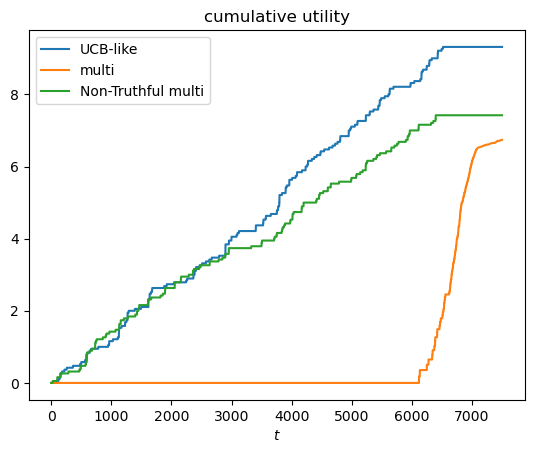

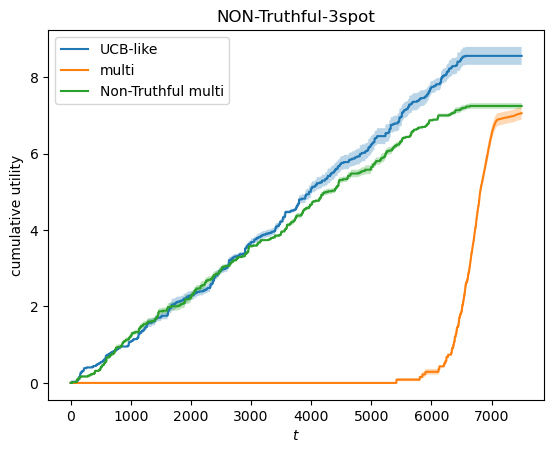

In [567]:
vett1 = np.cumsum(alg_utilities[0,:])
vett2 = np.cumsum(alg_utilities[1,:])
vett3 = np.cumsum(alg_utilities[2,:])
#vett1 = (alg_utilities[0,:])
#vett2 = (alg_utilities[1,:])
#vett3 = (alg_utilities[2,:])
title = "cumulative utility"
title2 = "NON-Truthful-3spot"
yaxis = "cumulative utility"
showPlotPoint4(vett1, vett2, vett3, title,args.T*args.n_users)
showPlot(utilities1, utilities2, utilities3, title2, yaxis ,args.T*args.n_users,n_epochs)

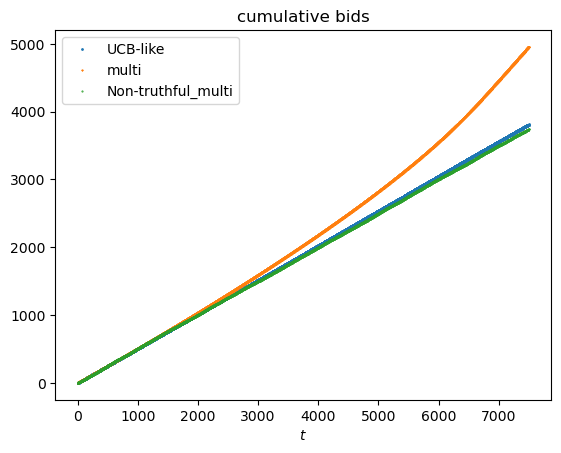

0


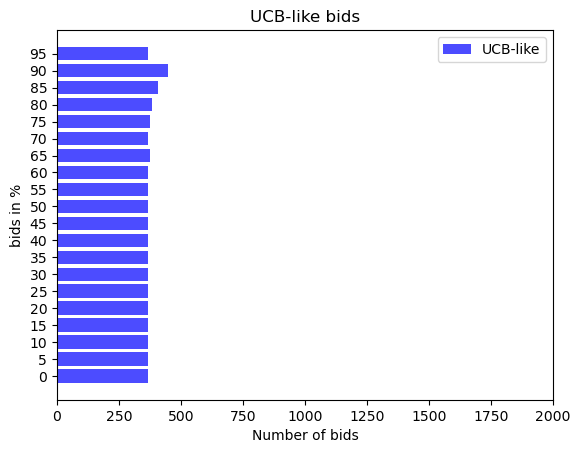

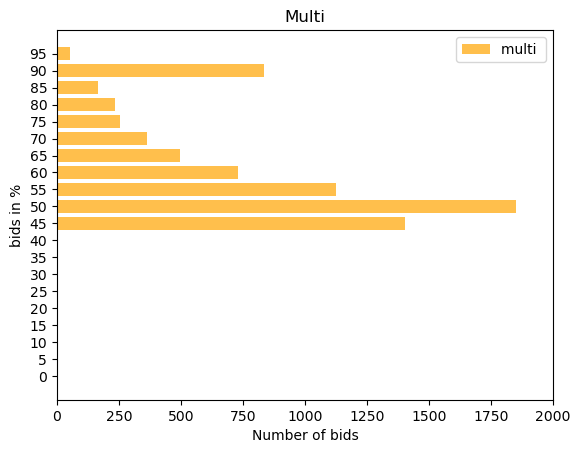

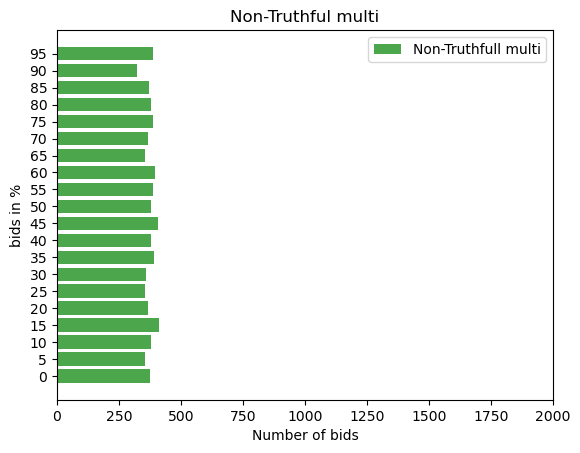

In [568]:
vett1 = np.cumsum(alg_bids[0,:])
vett2 = np.cumsum(alg_bids[1,:])
vett3 = np.cumsum(alg_bids[2,:])
title = "cumulative bids"

#showPlotPoint4(vett1, vett2, vett3, title, args.T*args.n_users)
showPlotPoint4Bids(vett1, vett2, vett3, title, args.T*args.n_users)
print(sum(alg_bids[2,:]<0))
title = "bids"
K_disc = discretize(args.T*args.n_users)
#showTimeBids(alg_bids[0,:],alg_bids[1,:],alg_bids[2,:], title, args.T*args.n_users, best_price_index = 0)
showPlotPulls(alg_bids[0,:],alg_bids[1,:],alg_bids[2,:], title, K_disc, best_price_index=0)

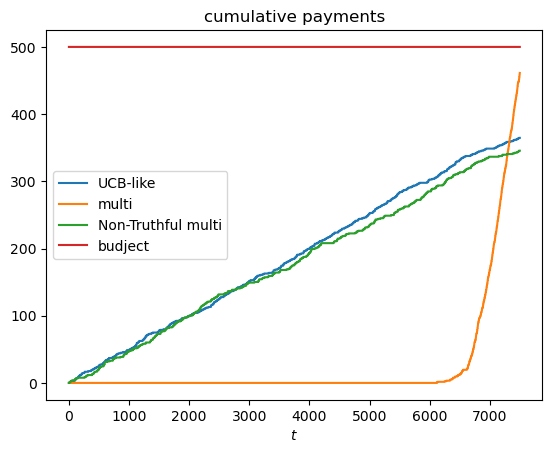

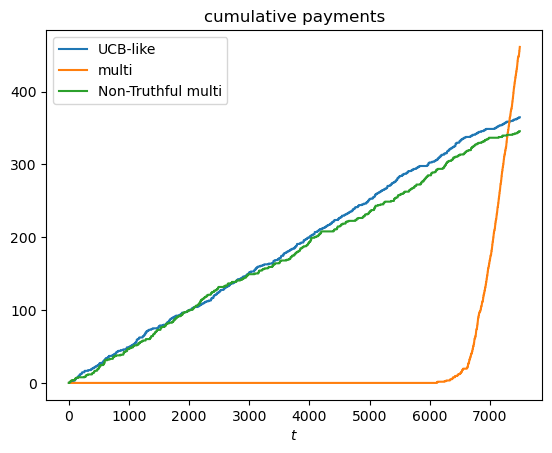

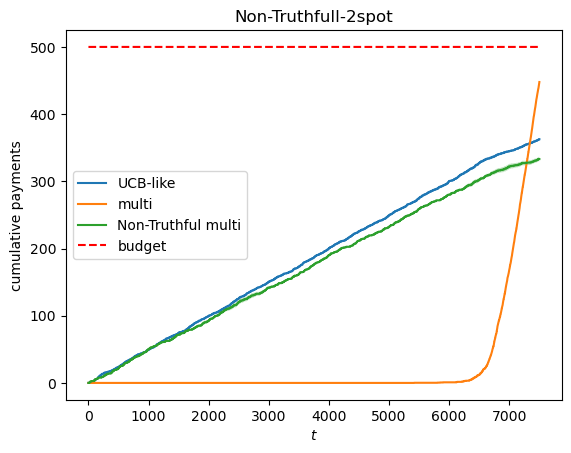

In [569]:
vett1 = np.cumsum(alg_payments[0,:])
vett2 = np.cumsum(alg_payments[1,:])
vett3 = np.cumsum(alg_payments[2,:])
title = "cumulative payments"

showPlotPoint4(vett1, vett2, vett3, title,args.T*args.n_users, args.B)
title2 = "Non-Truthfull-2spot"
yaxis = "cumulative payments"
showPlotPoint4(vett1, vett2, vett3, title,args.T*args.n_users)
showPlot(payments1, payments2, payments3, title2, yaxis ,args.T*args.n_users,n_epochs, args.B)